In [1]:
!if [ ! -e abalone.data ]; then wget http://archive.ics.uci.edu/ml/machine-learning-databases/abalone/abalone.data; fi

In [1]:
import pandas as pd

In [2]:
column_names = ["sex", "length", "diameter", "height", "whole weight", 
                "shucked weight", "viscera weight", "shell weight", "rings"]
data = pd.read_csv("../tests/abalone.data.xz", names=column_names)
print("Number of samples: %d" % len(data))
data.head()

Number of samples: 4177


,sex,length,diameter,height,whole weight,shucked weight,viscera weight,shell weight,rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


In [3]:
# for more complicated cases use sklearn.feature_extraction.DictVectorizer# for m 
for label in "MFI":
    data[label] = data["sex"] == label
del data["sex"]
data.head()

,length,diameter,height,whole weight,shucked weight,viscera weight,shell weight,rings,M,F,I
0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15,True,False,False
1,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7,True,False,False
2,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9,False,True,False
3,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10,True,False,False
4,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7,False,False,True


In [4]:
import numpy as np
from sklearn import model_selection, tree

y = data.rings.values
del data["rings"] # remove rings from data, so we can convert all the dataframe to a numpy 2D array.
X = data.values.astype(np.float)
train_X, test_X, train_y, test_y = model_selection.train_test_split(X, y) # splits 75%/25% by default

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:16: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Mapping, namedtuple, defaultdict, Sequence


In [5]:
model = tree.DecisionTreeClassifier()
model = model.fit(train_X, train_y)

In [6]:
model.score(test_X, test_y)

0.20095693779904306

In [7]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


(array([  17.,  431., 1648., 1388.,  329.,  228.,  100.,   29.,    4.,
           3.]),
 array([ 1. ,  3.8,  6.6,  9.4, 12.2, 15. , 17.8, 20.6, 23.4, 26.2, 29. ]),
 <a list of 10 Patch objects>)

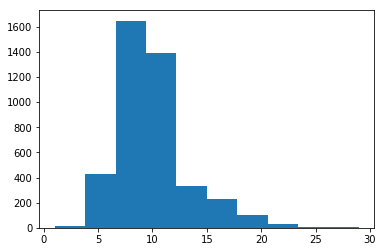

In [18]:
hist(y)

In [8]:
interval = len(y) / 2
ymap = {}
accum = 0
i = 0
for val in range(y.min(), y.max() + 1):
    delta = (y == val).sum()
    accum += delta
    if accum > interval:
        accum = delta
        i += 1
    ymap[val] = i
print(ymap)

{1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 1, 10: 1, 11: 1, 12: 1, 13: 2, 14: 2, 15: 2, 16: 2, 17: 2, 18: 2, 19: 2, 20: 2, 21: 2, 22: 2, 23: 2, 24: 2, 25: 2, 26: 2, 27: 2, 28: 2, 29: 2}


In [9]:
mapped_y = numpy.zeros(len(y), dtype=int)
for i, v in enumerate(y):
    mapped_y[i] = ymap[v]
train_X, test_X, train_y, test_y = model_selection.train_test_split(X, mapped_y)

In [67]:
params = {
    "min_samples_leaf": list(range(20, 30, 1)),
    "min_samples_split": list(range(2, 4, 1)),
}
gs = model_selection.GridSearchCV(tree.DecisionTreeClassifier(), params, n_jobs=3, verbose=1)
gs = gs.fit(X, mapped_y)
gs.score(X, mapped_y)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=3)]: Done  60 out of  60 | elapsed:    0.3s finished
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:718: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


0.7526933205649988

In [61]:
model.best_params_

{'min_samples_leaf': 26, 'min_samples_split': 2}

In [10]:
model = tree.DecisionTreeClassifier(min_samples_leaf=26)
model = model.fit(train_X, train_y)
print(model.score(train_X, train_y), model.score(test_X, test_y))
model = model.fit(X, mapped_y)

0.7563856960408685 0.6889952153110048


In [66]:
from sklearn.tree import _tree

total = 0

def tree_to_code(tree, feature_names):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]
    print("def tree({}):".format(", ".join(feature_names)))

    def recurse(node, depth):
        indent = "  " * depth
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            print("{}if {} <= {}:".format(indent, name, threshold))
            recurse(tree_.children_left[node], depth + 1)
            print("{}else:  # if {} > {}".format(indent, name, threshold))
            recurse(tree_.children_right[node], depth + 1)
        else:
            global total
            total += tree_.value[node].sum()
            print("{}return {}".format(indent, tree_.value[node]))

    recurse(0, 1)

tree_to_code(model, data.columns)

def tree(length, diameter, height, whole weight, shucked weight, viscera weight, shell weight, M, F, I):
  if shell weight <= 0.1537500023841858:
    if I <= 0.5:
      if shucked weight <= 0.22600000351667404:
        if diameter <= 0.2775000035762787:
          if diameter <= 0.23250000178813934:
            return [[24.  3.  0.]]
          else:  # if diameter > 0.23250000178813934
            if shucked weight <= 0.07750000059604645:
              return [[10. 16.  0.]]
            else:  # if shucked weight > 0.07750000059604645
              return [[22.  7.  1.]]
        else:  # if diameter > 0.2775000035762787
          if height <= 0.12249999865889549:
            if shucked weight <= 0.12524999678134918:
              return [[ 8. 28.  3.]]
            else:  # if shucked weight > 0.12524999678134918
              if shell weight <= 0.1197499968111515:
                return [[24. 11.  2.]]
              else:  # if shell weight > 0.1197499968111515
                return [[

In [11]:
def tree_to_rules(tree, feature_names):
    from sklearn.tree import _tree as Tree
    
    tree = tree.tree_
    feature_names = [
        feature_names[i] if i != Tree.TREE_UNDEFINED else "TREE_UNDEFINED"
        for i in tree.feature
    ]
    queue = [(0, tuple())]
    rules = []
    while queue:
        node, path = queue.pop()
        if tree.feature[node] != Tree.TREE_UNDEFINED:
            name = feature_names[node]
            threshold = tree.threshold[node]
            queue.append((tree.children_left[node], path + ((name, False, threshold),)))  # <= threshold
            queue.append((tree.children_right[node], path + ((name, True, threshold),)))  # > threshold
        else:
            breakpoint()
            rules.append((path, tuple(tree.value[node][0])))
    return rules

In [12]:
rules = tree_to_rules(model, data.columns)

> <ipython-input-11-b74bbc27e0fa>(20)tree_to_rules()
-> rules.append((path, tuple(tree.value[node][0])))
(Pdb) p tree.value[node][0]
array([ 0., 16., 11.])
(Pdb) tree.value[node][0].dtype
dtype('float64')
(Pdb) q


BdbQuit: 

In [93]:
rules[0]

((('shell weight', True, 0.1522499993443489),
  ('shell weight', True, 0.25425000488758087),
  ('shucked weight', True, 0.44474999606609344),
  ('shell weight', True, 0.3894999921321869),
  ('shucked weight', True, 0.5852499902248383),
  ('shell weight', True, 0.5092499852180481),
  ('shucked weight', True, 0.8075000047683716),
  ('shucked weight', True, 1.001249998807907)),
 (0.0, 22.0, 6.0))

In [102]:
from collections import defaultdict

def merge_rules(rules):
    new_rules = []
    for rule, freqs in rules:
        min_vals = {}
        max_vals = {}
        flags = defaultdict(int)
        for name, cmp, val in rule:
            if cmp:
                min_vals[name] = max(min_vals.get(name, val), val)
                flags[name] |= 1
            else:
                max_vals[name] = min(max_vals.get(name, val), val)
                flags[name] |= 2
        new_rule = []
        for key, bits in sorted(flags.items()):
            if bits & 2:
                new_rule.append((key, False, max_vals[key]))
            if bits & 1:
                new_rule.append((key, True, min_vals[key]))
        new_rules.append((new_rule, freqs))
    return new_rules

In [103]:
rules2 = merge_rules(rules)

(array([ 1.,  0.,  8., 14., 35., 20., 19., 15.,  5.,  2.]),
 array([ 3. ,  3.9,  4.8,  5.7,  6.6,  7.5,  8.4,  9.3, 10.2, 11.1, 12. ]),
 <a list of 10 Patch objects>)

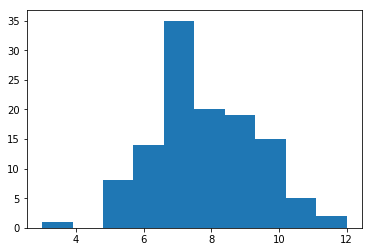

In [107]:
hist([len(r[0]) for r in rules])

(array([ 1.,  6.,  0., 20.,  0., 37., 36.,  0., 17.,  2.]),
 array([2. , 2.6, 3.2, 3.8, 4.4, 5. , 5.6, 6.2, 6.8, 7.4, 8. ]),
 <a list of 10 Patch objects>)

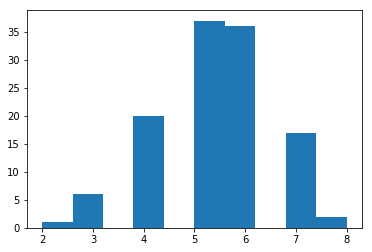

In [108]:
hist([len(r[0]) for r in rules2])

In [122]:
print(len(rules2))

119


In [229]:
def compile_rules(rules, feature_names):
    findex = {k: i for i, k in enumerate(feature_names)}
    vals = defaultdict(set)
    for rule, _ in rules:
        for name, _, val in rule:
            vals[name].add(val)
    vals = {findex[name]: sorted(v) for name, v in vals.items()}
    model = {k: ([[] for v in ts] + [[]], ts, set()) for k, ts in vals.items()}
    for ri, (rule, _) in enumerate(rules):
        allnis = set(model)
        names = set()
        for name, cmp, thr in rule:
            ni = findex[name]
            allnis.discard(ni)
            ptrs, vals, _ = model[ni]
            if name not in names:
                for ptr in ptrs:
                    ptr.append(ri)
                names.add(name)
            for ptr, brdr in zip(ptrs, vals + [1<<31]):
                # brdr_{-1} < x <= brdr
                if cmp:
                    # x > thr
                    if brdr <= thr:
                        # x <= brdr <= thr < x - impossible
                        if ptr and ptr[-1] == ri:
                            ptr.pop()
                else:
                    # x <= thr
                    if brdr > thr:
                        # x <= thr < brdr
                        # x <= thr <= brdr_{-1} < x - impossible
                        if ptr and ptr[-1] == ri:
                            ptr.pop()
        for ni in allnis:
            model[ni][2].add(ri)
    return model

In [244]:
def eval_rules(rules, X, Y, feature_names):
    compiled = compile_rules(rules, feature_names)
    matched = 0
    for xi, (x, y) in enumerate(zip(X, Y)):
        ris = set(range(len(rules)))
        for i, v in enumerate(x):
            try:
                ptrs, thrs, skips = compiled[i]
            except KeyError:
                continue
            possible = ptrs[searchsorted(thrs, v)]
            ris = ris.intersection(set(possible).union(skips))
        if len(ris) == 0:
            print("no rule!")
            continue
        if len(ris) > 1:
            print("%d matching rules for X[%d]" % (len(ris), xi))
            maxfreq = 0
            maxri = -1
            for ri in ris:
                freqs = rules[ri][1]
                maxfreqi = argmax(freqs)
                if freqs[maxfreqi] > maxfreq:
                    maxfreq = freqs[maxfreqi]
                    maxri = ri
        else:
            maxri = next(iter(ris))
        if argmax(rules[maxri][1]) == y:
            matched += 1
    return matched / len(Y)

In [187]:
{k: i for i, k in enumerate(data.columns)}

{'F': 8,
 'I': 9,
 'M': 7,
 'diameter': 1,
 'height': 2,
 'length': 0,
 'shell weight': 6,
 'shucked weight': 4,
 'viscera weight': 5,
 'whole weight': 3}

In [183]:
def print_x(x):
    for i, v in enumerate(x):
        print(data.columns[i], "=", v)

In [184]:
print_x(X[0])

length = 0.455
diameter = 0.365
height = 0.095
whole weight = 0.514
shucked weight = 0.2245
viscera weight = 0.10099999999999999
shell weight = 0.15
M = 1.0
F = 0.0
I = 0.0


In [245]:
eval_rules(rules2, X, mapped_y, data.columns)

0.7526933205649988

In [251]:
verbs = defaultdict(int)
for branch, _ in rules2:
    for rule in branch:
        verbs[rule] += 1
verb_vals = list(verbs.values())

(array([174.,  25.,  10.,   7.,   7.,   0.,   1.,   0.,   0.,   2.]),
 array([ 1. ,  3.3,  5.6,  7.9, 10.2, 12.5, 14.8, 17.1, 19.4, 21.7, 24. ]),
 <a list of 10 Patch objects>)

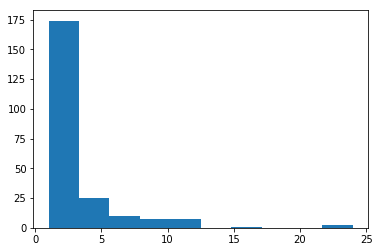

In [253]:
hist(verb_vals)

In [ ]:
from scipy.stats import fisher_exact

def throw_insignificant_parts(rule, X, Y, feature_names):
    findex = {k: i for i, k in enumerate(feature_names)}
    verbs, freqs = rule
    cls = argmax(freqs)
    for name, cmp, thr in verbs:
        table = np.zeros((2, 2), dtype=int)
        for x, y in zip(X, Y):
            val = x[findex[name]]
            table[(val <= thr) == cmp, cls != y] += 1
        
        print(name, cmp, thr, )